# Annotated map: Antarctica & Antarctic Peninsula

In [2]:
import pandas
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.transforms as mtrans
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import matplotlib.patheffects as PathEffects

import cartopy.crs as ccrs
import cartopy.feature as cfe

In [3]:
### see: https://www.fatiando.org/rockhound/latest/gallery/bedmap2.html
import rockhound

In [4]:
def draw_box(region, transform=None ):
    '''
    Draw box around a region on a map
    region = [west,east,south,north]
    '''

    west, east, south, north = region['west'],region['east'],region['south'],region['north']
    color = region['color']

    if transform == None:
        transform = ccrs.PlateCarree()

    plt.plot([west, west], [south,north], color, transform=transform, linewidth=0.7)
    plt.plot([east,east], [south,north], color, transform=transform, linewidth=0.7)
    arc = np.linspace( west,east,20 )[0:-1]
    dx = arc[1] - arc[0]
    for i in arc: 
        plt.plot([i,i+dx], [south,south], color, transform=transform, linewidth=0.7)
        plt.plot([i,i+dx], [north,north], color, transform=transform, linewidth=0.7)

def plot_ice_masses(ax):
    # Filled and outlined coastlines and ice shelves
    ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '50m',
                                            edgecolor='LightGrey', 
                                            facecolor='LightGrey', linewidth=0.1 ) )
    ax.add_feature(cfe.NaturalEarthFeature('physical', 'coastline', '50m',
                                            edgecolor='DarkGrey', 
                                            facecolor='DarkGrey', linewidth=0.2) )
    ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m',
                                            edgecolor='DarkGrey', 
                                            facecolor='none', linewidth=0.1 ) )

## Set plot options

In [14]:
### Plot regional box on panel a
regional_box = {'west':285, 'south':-75, 'east':306, 'north':-60, 'color':'black'}
draw_regional_box = False   ### True or False

### Plot elevation on panel b (slow!!!)
plot_elev = True            ### True or False

## Plot Figure

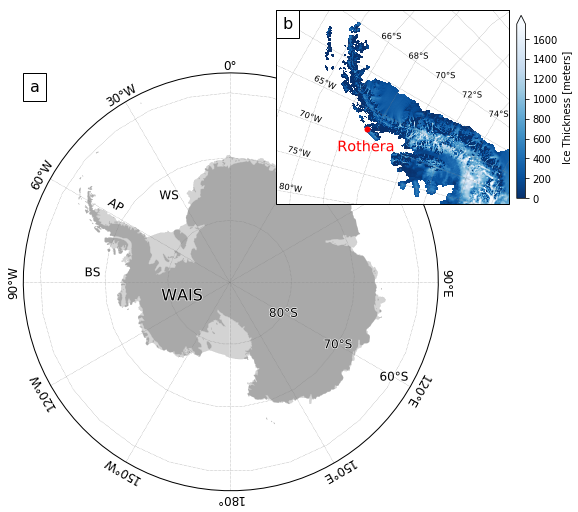

In [20]:
### Setup figure
fig = plt.figure(figsize=[ 9, 9.5])

### Setup panels
gs1 = gridspec.GridSpec(2, 2, width_ratios=[1,0.1], height_ratios=[0.1,1])
gs2 = gridspec.GridSpec(2, 2, width_ratios=[1,1.2], height_ratios=[1.2,1])


'''
Main Plot (Panel a)
'''

ax2 = fig.add_subplot(gs1[1,0], 
                      projection=ccrs.Stereographic(central_longitude=0., 
                                                    central_latitude=-90.) )

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax2.set_boundary(circle, transform=ax2.transAxes)

lat_extend = -57
ax2.set_extent([0, 359, -80, lat_extend], ccrs.PlateCarree())

plot_ice_masses(ax2)

### Draw regional Box
if draw_regional_box: draw_box(region)

ax2.gridlines( 
              xlocs=np.arange(0,361,30), 
              ylocs=np.arange(-90, 0, 10), color='Grey', 
              linestyle=':', linewidth=0.5, 
              transform=ccrs.PlateCarree() )

# add grid labels
for lon in range(0,360,180):
    ax2.text( -lon, lat_extend, str(lon)+u'\260', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', rotation=lon, rotation_mode='anchor',
        size='large')
for lon in range(30,180,30):
    ax2.text( lon, lat_extend, str(lon)+u'\260E', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', rotation=-lon, rotation_mode='anchor',
        size='large')
for lon in range(30,180,30):
    ax2.text( -lon, lat_extend, str(lon)+u'\260W', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', rotation=lon, rotation_mode='anchor',
        size='large')
for lat in range(-80,lat_extend,10):
    txt = ax2.text( 120, lat, str(-lat)+u'\260S', transform=ccrs.PlateCarree(),
        ha='center', va='center', size='large',
        bbox={'facecolor':'none','edgecolor':'none','pad':0.5} )
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.3, foreground='w')])


###  Add markers
AntLabels = [ 'AP', 'BS', 'WS' , 'WAIS' ]
AntLons   = [ -56., -86., -35., -106.  ]
AntLats   = [ -68., -68., -73. , -82.   ]
rotation  = [ -30., -0. ,  0. ,  0.    ]
for i2 in range(len(AntLabels)):
	font_size=12
	if AntLabels[i2] == 'WAIS': font_size=font_size+4
	at_x, at_y = ax2.projection.transform_point( AntLons[i2], AntLats[i2], src_crs=ccrs.PlateCarree() )
	txt = ax2.annotate(AntLabels[i2], xy=(at_x, at_y), 
	    color='k', rotation=rotation[i2],
	    ha='center', va='center', size=font_size)
	txt.set_path_effects([PathEffects.withStroke(linewidth=1.3, foreground='w')])

# Add panel label to top right
ax2.add_artist(AnchoredText('a', loc=2, borderpad=0.0, prop=dict(size=16) ))



'''
Zoomed in plot (Panel b)
'''

ax2 = fig.add_subplot(gs2[0,1], 
                      projection=ccrs.Stereographic(central_longitude=0., 
                                                    central_latitude=-90.) )

extent = {'west':285, 'south':-75, 'east':305, 'north':-62.7}
ax2.set_extent([extent['west'],extent['east'],extent['south'],extent['north']], 
               ccrs.PlateCarree())

### Plot ice sheet elevation
if plot_elev:
    bedmap = rockhound.fetch_bedmap2(datasets=["thickness"])
    pc = bedmap.thickness.plot.pcolormesh(
            ax=ax2, cmap='Blues_r', 
            cbar_kwargs=dict(pad=0.03, fraction=0.036), 
            vmin=0, vmax=1750 )
else:
    plot_ice_masses(ax2)


grid_dx = 5
grid_dy = 2
ax2.gridlines( xlocs=np.arange(0,360,grid_dx), ylocs=np.arange(-90, 0, grid_dy), 
              color='Grey', linestyle=':', linewidth=0.5, 
              transform=ccrs.PlateCarree() )

grid_labels_lons = np.arange(280,300,5)
grid_labels_lats = np.arange(-74, -65, 2)

for lon in grid_labels_lons:
    if lon > 180.: lon = (360. - lon).astype(int)
    txt = ax2.text( -lon, -64., str(lon)+u'\260W', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', rotation=lon-90., rotation_mode='anchor',
        size='small')
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.3, foreground='w')])
for lat in grid_labels_lats:
    txt = ax2.text( 306, lat, str(-lat)+u'\260S', transform=ccrs.PlateCarree(),
        ha='center', va='center', size='small',
        bbox={'facecolor':'none','edgecolor':'none','pad':0.5} )
    txt.set_path_effects([PathEffects.withStroke(linewidth=1.3, foreground='w')])

### Plot location label
Rothera  = [360.-68.07, -67.43]

ax2.plot(Rothera[0], Rothera[1], color='r', marker='o', markeredgewidth=1.0, markersize=5., 
             transform=ccrs.PlateCarree())
at_x, at_y = ax2.projection.transform_point(Rothera[0], Rothera[1], 
                                            src_crs=ccrs.PlateCarree())
txt1 = ax2.annotate('Rothera', xy=(at_x, at_y), xytext=(-30., -22.), xycoords='data', 
                    textcoords='offset points', color='r', size='x-large')
txt1.set_path_effects([PathEffects.withStroke(linewidth=1.3, foreground='w')])

### Plot panel label
ax2.add_artist(AnchoredText('b', loc=2, borderpad=0.0, prop=dict(size=16) ))




'''
Make plot
'''
# plt.tight_layout()
plt.savefig('annotated_map.jpg', dpi=300)